In [1]:
import os
import seaborn as sns
from scipy.spatial import distance as dist
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import imutils
import numpy as np
from PIL import Image
from shared_astro_utils.matching_utils import match_galaxies_to_catalog_pandas  # or, if you're not me, grab code from crossmatch_catalogs.ipynb
from imutils import contours

from astropy.cosmology import FlatLambdaCDM
import numpy as np
from astropy import units as u
cosmo = FlatLambdaCDM(H0=67.8, Om0=0.308)


In [2]:
bar_df = pd.read_csv('/home/walml/repos/zoobot-3d/data/hoyle_barlengths.csv')

In [3]:
bar_df

,objid,ra,dec,length_avg,length_stdev,width_avg,width_stdev,length_scaled,bar_meas
0,587722981747982465,198.05199,-1.095136,5.841887,0.320314,2.328472,0.951038,0.461109,3
1,587722981752438860,208.22692,-1.114616,3.240697,0.741893,0.603216,0.197862,0.339584,4
2,587722982286426253,201.59344,-0.816576,5.171054,0.606520,1.434728,0.117809,0.406783,3
3,587722982290686153,211.35525,-0.811344,10.311853,2.352807,3.483071,1.954910,0.428145,4
4,587722982292521047,215.52468,-0.669283,11.513937,3.133255,2.497071,1.021334,0.439008,4
...,...,...,...,...,...,...,...,...,...
3145,588848901005246604,223.04204,0.783986,6.470187,1.389767,1.569311,1.105357,0.493286,4
3146,588848901007933476,229.10432,0.708052,6.125565,1.280630,1.590883,1.110799,0.316473,4
3147,588848901523636294,180.87304,1.229350,4.699296,0.352203,1.425113,0.689318,0.341577,5
3148,588848901525930026,186.02036,1.189801,5.349061,1.345254,1.002916,0.550130,0.366885,4


In [4]:
on_local = os.path.isdir('/home/walml/repos/zoobot-3d/')
if on_local:
    base_dir = '/home/walml/repos/zoobot-3d/'
else:
    base_dir = '/share/nas2/walml/galaxy_zoo/segmentation/'

df = pd.read_parquet(base_dir + 'data/test_catalog.parquet')
df['spiral_mask_loc'] = df['spiral_mask_loc'].str.replace('/Users/user', '/home/walml')
print(df['spiral_mask_loc'].iloc[0])
df['spiral_mask_exists'] = df['spiral_mask_loc'].apply(os.path.isfile)
assert any(df['spiral_mask_exists'])
df = df.query('spiral_mask_exists').reset_index(drop=True)
df['spiral_mask_loc'] = ''

checkpoint_path = base_dir + 'outputs/run_1695899881.3925836/epoch=93-step=1880.ckpt'
# checkpoint_path = base_dir + 'outputs/run_1695938854.2480044/epoch=91-step=1840.ckpt'
save_dir = os.path.dirname(checkpoint_path) + '/predictions/'
df['zoobot_bar_mask_loc'] = df['dr8_id'].apply(lambda x: save_dir + f'/{x}_bar_pred_viz.png')

/home/walml/repos/zoobot-3d/data/gz3d/segmaps/masks_constnorm/gz3d_1-364977_127_14727898_spiral.jpg


In [5]:
df['zoobot_bar_mask_loc'].iloc[0]

'/home/walml/repos/zoobot-3d/outputs/run_1695899881.3925836/predictions//374395_3484_bar_pred_viz.png'

In [6]:
matched, _ = match_galaxies_to_catalog_pandas(bar_df, df)
len(matched)

140

In [7]:
matched['has_bar_prediction'] = matched['zoobot_bar_mask_loc'].apply(os.path.isfile)

In [8]:
matched = matched.query('has_bar_prediction')
len(matched)

140

In [9]:
len(matched['zoobot_bar_mask_loc'])

140

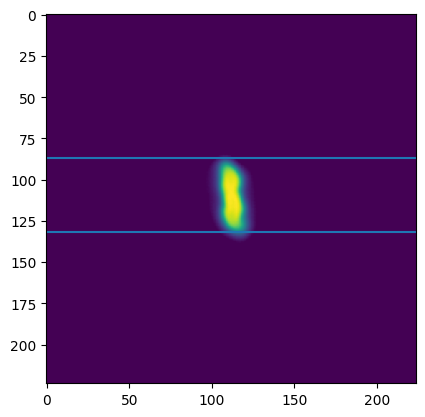

In [10]:
im = cv2.imread(matched['zoobot_bar_mask_loc'].iloc[0],  cv2.IMREAD_GRAYSCALE)
plt.imshow(im) 
plt.axhline(87)
plt.axhline(132)
# 45 pixels!

In [11]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)


In [12]:
def measure_bar_width_pixels(mask_loc, debug=False):
    # simplified version of
    # https://pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/
    im = cv2.imread(mask_loc,  cv2.IMREAD_GRAYSCALE)

    im_nonzero = im[im > 0]
    thresh = np.percentile(im_nonzero.flatten(), 80)
    im_bw = cv2.threshold(im, thresh, 255, cv2.THRESH_BINARY)[1]

    # (thresh, im_bw) = cv2.threshold(im, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    cnts = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    (cnts, _) = contours.sort_contours(cnts)
    if len(cnts) > 1:
        return np.nan
    c = cnts[0]
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    # https://stackoverflow.com/questions/29739411/what-does-cv2-cv-boxpointsrect-return
    # corners of rotated box (pixel coordinates) enclosing contour
    # x_width = box[:, 0].max() - box[:, 0].min()
    # y_width = box[:, 1].max() - box[:, 1].min()
    # box_width = np.sqrt(x_width ** 2 + y_width ** 2)

    # unpack the ordered bounding box, then compute the midpoint
	# between the top-left and top-right coordinates, followed by
	# the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)
    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)
    # draw the midpoints on the image
    cv2.circle(im, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(im, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(im, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(im, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
    box_width = max(dA, dB)

    if debug:
        fig, (ax1, ax0) = plt.subplots(ncols=2)
        ax0.imshow(im)
        ax1.imshow(im_bw)
        ax0.axis('off')
        ax1.axis('off')
        return box_width, fig
    else:
        return box_width

(54.51834553615874, <Figure size 640x480 with 2 Axes>)

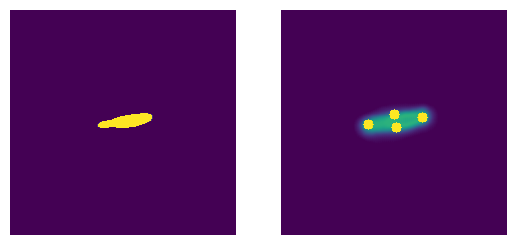

In [13]:
measure_bar_width_pixels(matched['zoobot_bar_mask_loc'].iloc[114], debug=True)

In [14]:
matched['bar_width_pixels'] = matched['zoobot_bar_mask_loc'].apply(measure_bar_width_pixels)

In [15]:
matched['bar_width_pixels']

0      32.190837
1      38.013156
2      20.000000
3      49.244289
4      49.368512
         ...    
135    38.000000
136    23.259407
137    39.458839
138    23.436083
139    22.141590
Name: bar_width_pixels, Length: 140, dtype: float64

In [16]:
# matched['est_dr5_pixscale']  # arcsec/pixel
matched['bar_width_arcsec'] = matched['bar_width_pixels'] * matched['est_dr5_pixscale']

In [17]:
nsa = pd.read_parquet('/media/walml/beta/galaxy_zoo/decals/catalogs/nsa_v1_0_1_key_cols.parquet', columns=['iauname', 'redshift'])
matched = pd.merge(nsa, matched, on='iauname')

In [18]:
matched['angular_diameter_distance'] = cosmo.angular_diameter_distance(z=matched['redshift'])
# matched['angular_diameter_distance']

# d_A = 
# print(d_A) # 946.9318492873492 Mpc

# theta = 737.28*u.arcsec
# distance_Mpc = (theta * d_A).to(u.Mpc, u.dimensionless_angles()) # unit is Mpc only now

# print(distance_Mpc)

In [19]:
matched['bar_width_kpc'] = matched['bar_width_arcsec'] * matched['angular_diameter_distance'] / 117
# matched['bar_width_kpc'] = matched['bar_width_arcsec'] * matched['angular_diameter_distance'] / 100

In [20]:
matched['bar_width_kpc'] = np.array(matched['bar_width_kpc']).astype(float)

In [21]:
from matplotlib.ticker import MaxNLocator

In [33]:
# new for review - add a stats test
r_corr = pd.Series(matched['bar_width_kpc']).corr(matched['length_avg'])
mean_abs_error = np.abs(matched['bar_width_kpc'] - matched['length_avg']).mean()

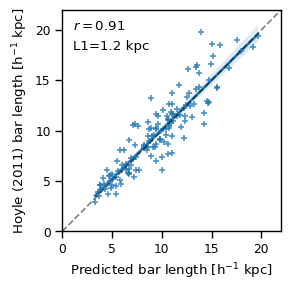

In [37]:
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(3, 3))
# plt.scatter(matched['bar_width_kpc'] , matched['length_avg'], marker='+')
sns.regplot(x=matched['bar_width_kpc'].astype(float), y=matched['length_avg'].astype(float), marker='+', robust=True, ax=ax)
ax.set_xlabel('Predicted bar length [h$^{-1}$ kpc]')
ax.set_ylabel('Hoyle (2011) bar length [h$^{-1}$ kpc]')
ax.set_xlim([0., 22.])
ax.set_ylim([0., 22.])
ax.plot([0, 22], [0, 22], color='k', alpha=0.5, linestyle='--')
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

ax.text(1.1, 20, "$r={:1.2f}$".format(r_corr))
ax.text(1.1, 18, "L1={:1.1f} kpc".format(mean_abs_error))

plt.tight_layout()
plt.savefig('hoylebarcomparisonwithstats.pdf')



0.9118723027786848

1.2016560266461482

In [23]:
matched['error'] = np.abs(np.array(matched['bar_width_kpc']).astype(float) - np.array(matched['length_avg']).astype(float))
matched.sort_values('error')['error']

91     0.005988
103    0.010084
139    0.015564
83     0.029666
4      0.034206
         ...   
116    4.321746
8      5.909656
30          NaN
75          NaN
114         NaN
Name: error, Length: 140, dtype: float64